In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [6]:
# declarations
base_dir = "/home/sparrow/genomicTools/gtex_stats/"
out_dir = "/home/sparrow/JHU/tx_noise/"
hg38_fa = "/home/sparrow/genomicData/hg38/hg38_p8.fa"

readlen = 101

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

real_counts_path = out_dir+"/sim_samples_single_joint/res_distrib.real.sample0/sim_counts_matrix"
nonint_counts_path = out_dir+"/sim_samples_single_joint/res_distrib.nonint.sample0/sim_counts_matrix"
int_counts_path = out_dir+"/sim_samples_single_joint/res_distrib.int.sample0/sim_counts_matrix"
pol_counts_path = out_dir+"/sim_samples_single_joint/res_distrib.pol.sample0/sim_counts_matrix"
real_counts_path

'/home/sparrow/JHU/tx_noise//sim_samples_single_joint/res_distrib.real.sample0/sim_counts_matrix'

In [3]:
# begin by preprocessing the rda n R if not possible to load through python
#   from here need to get:
#      1. number of reads
#      2. TPM
#      3. transcript name
#      4. transcript type
#      5. gene type
# next need to get the TPM and transcript names from the results

In [7]:
# let'scheck if groupy changes order
real_gtf = pd.read_csv(out_dir+"sim_samples_single_joint/res_distrib.real.sample0.gtf",names=gff3cols,comment="#",sep="\t")
edf_real = real_gtf[real_gtf["type"]=="exon"].reset_index(drop=True)
edf_real["gid"] = edf_real["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
edf_real["tid"] = edf_real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
edf_real["len"] = edf_real["end"]-edf_real["start"]
edf_real = edf_real[["tid","gid","len"]]
edf_real = edf_real.groupby("tid").agg({"len":"sum","gid":lambda x: ";".join(set(x))}).reset_index()

In [8]:
tdf_real = real_gtf[real_gtf["type"]=="transcript"].reset_index(drop=True)
tdf_real["tid"] = tdf_real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
tdf_real = tdf_real[["tid"]]
edf_real.head()

,tid,len,gid
0,ALL_00000021,917,XLOC_000006
1,ALL_00000484,4222,XLOC_000041
2,ALL_00006773,8649,XLOC_000168
3,ALL_00007545,3107,XLOC_000193
4,ALL_00007674,1575,XLOC_000203


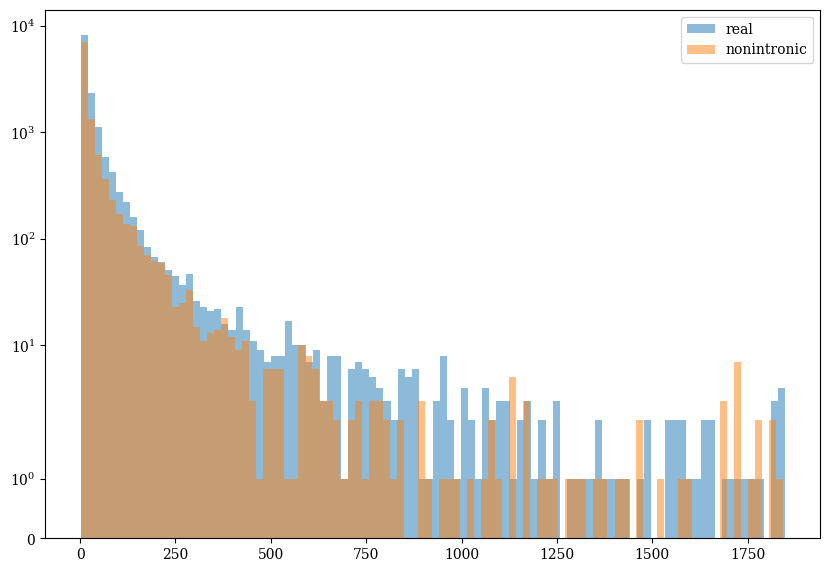

In [9]:
# first let'sbegin by checking the distributions that we've got from the data
# namely we are interested at the expression (TPM) of real and nonint
#   and the fraction of expression per each locus that comes from real vs non-intronic
real_gtf = pd.read_csv(out_dir+"sim_samples_single_joint/res_distrib.real.sample0.gtf",names=gff3cols,comment="#",sep="\t")
tdf_real = real_gtf[real_gtf["type"]=="transcript"].reset_index(drop=True)
edf_real = real_gtf[real_gtf["type"]=="exon"].reset_index(drop=True)
edf_real["gid"] = edf_real["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
edf_real["tid"] = edf_real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
edf_real["len"] = edf_real["end"]-edf_real["start"]
edf_real = edf_real[["tid","gid","len"]]
tdf_real["tid"] = tdf_real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
tdf_real = tdf_real[["tid"]]
edf_real = edf_real.groupby("tid").agg({"len":"sum","gid":lambda x: ";".join(set(x))}).reset_index()
edf_real = tdf_real.merge(edf_real,on="tid",how="inner")
edf_real["tid2"] = tdf_real["tid"]
assert len(edf_real[~(edf_real["tid"]==edf_real["tid2"])])==0,"incorrect ordering after groupping"
assert len(edf_real[edf_real["gid"].str.contains(";")]) == 0,"multiple loci groupped together"
edf_real.drop("tid2",axis=1,inplace=True)
edf_real.columns = ["tid","elen","gid"]
real_exp = pd.read_csv(out_dir+"sim_samples_single_joint/res_distrib.real.sample0.exp",names=["cov"])
edf_real["cov"] = real_exp["cov"]
# now to get the number of reads
edf_real["nr"] = edf_real["elen"]*edf_real["cov"]
# now to get the TPM we need the following
# TPM is very similar to RPKM and FPKM. The only difference is the order of operations.
#     Here’s how you calculate TPM:

# 1. Divide the read counts by the length of each gene in kilobases.
#     This gives you reads per kilobase (RPK).
edf_real["kelen"] = edf_real["elen"]/1000
edf_real["rpk"] = edf_real["nr"]/edf_real["kelen"]
# 2. Count up all the RPK values in a sample and divide this number by 1,000,000.
#     This is your “per million” scaling factor
pm_sf = edf_real["rpk"].sum()/1000000
# 3. Divide the RPK values by the “per million” scaling factor. This gives you TPM.
edf_real["tpm"] = edf_real["rpk"]/pm_sf
nonint_gtf = pd.read_csv(out_dir+"sim_samples_single_joint/res_distrib.nonint.sample0.gtf",names=gff3cols,comment="#",sep="\t")
tdf_nonint = nonint_gtf[nonint_gtf["type"]=="transcript"].reset_index(drop=True)
edf_nonint = nonint_gtf[nonint_gtf["type"]=="exon"].reset_index(drop=True)
edf_nonint["gid"] = edf_nonint["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
edf_nonint["tid"] = edf_nonint["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
edf_nonint["len"] = edf_nonint["end"]-edf_nonint["start"]
edf_nonint = edf_nonint[["tid","gid","len"]]
tdf_nonint["tid"] = tdf_nonint["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
tdf_nonint = tdf_nonint[["tid"]]
edf_nonint = edf_nonint.groupby("tid").agg({"len":"sum","gid":lambda x: ";".join(set(x))}).reset_index()
edf_nonint = tdf_nonint.merge(edf_nonint,on="tid",how="inner")
edf_nonint["tid2"] = tdf_nonint["tid"]
assert len(edf_nonint[~(edf_nonint["tid"]==edf_nonint["tid2"])])==0,"incorrect ordering after groupping"
assert len(edf_nonint[edf_nonint["gid"].str.contains(";")]) == 0,"multiple loci groupped together"
edf_nonint.drop("tid2",axis=1,inplace=True)
edf_nonint.columns = ["tid","elen","gid"]
nonint_exp = pd.read_csv(out_dir+"sim_samples_single_joint/res_distrib.nonint.sample0.exp",names=["cov"])
nonint_exp.head()
edf_nonint["cov"] = nonint_exp["cov"]
edf_nonint["nr"] = edf_nonint["elen"]*edf_nonint["cov"]
edf_nonint["kelen"] = edf_nonint["elen"]/1000
edf_nonint["rpk"] = edf_nonint["nr"]/edf_nonint["kelen"]
pm_sf = edf_nonint["rpk"].sum()/1000000
edf_nonint["tpm"] = edf_nonint["rpk"]/pm_sf

# now lets look at the fraction then - this time we need to merge the two on the parent locus
# get sum of expressions for each locus for each type
gdf_real = edf_real[["gid","tid","tpm"]].groupby(by="gid").agg({"tid":"count","tpm":"sum"}).reset_index()
gdf_real.columns = ["gid","nt_real","tpm_real"]
gdf_nonint = edf_nonint[["gid","tid","tpm"]].groupby(by="gid").agg({"tid":"count","tpm":"sum"}).reset_index()
gdf_nonint.columns = ["gid","nt_nonint","tpm_nonint"]
gdf = gdf_real.merge(gdf_nonint,on="gid",how="outer",indicator=True)
assert len(gdf[gdf["_merge"]=="left"]) == 0,"non_matching loci"
# compute the fraction
gdf["frac"] = gdf["tpm_real"]/(gdf["tpm_real"]+gdf["tpm_nonint"])
# now need to round things off a bit
gdf["tpm_real"] = gdf["tpm_real"].apply(np.ceil)
gdf["tpm_nonint"] = gdf["tpm_nonint"].apply(np.ceil)

# now to compare the expression distributions of each
fig1 = plt.subplots(figsize=(10,7),dpi=100)
max_common = max(list(set(gdf["tpm_real"]).intersection(gdf["tpm_nonint"])))
plt.hist(gdf[gdf["tpm_real"]<max_common]["tpm_real"],bins=100, alpha=0.5, label='real')
plt.hist(gdf[gdf["tpm_nonint"]<max_common]["tpm_nonint"],bins=100, alpha=0.5, label='nonintronic')
plt.yscale("symlog")
plt.legend(loc='upper right')

/home/sparrow/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sparrow/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


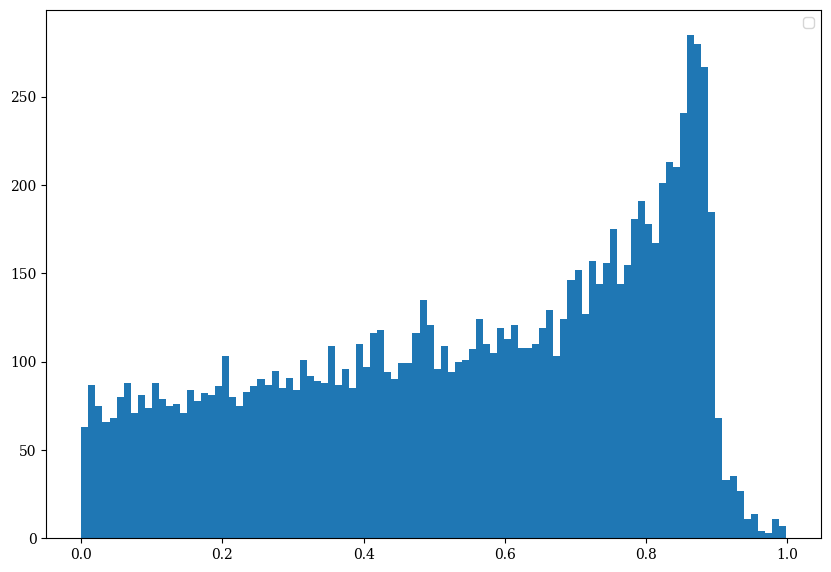

In [10]:
fig1 = plt.subplots(figsize=(10,7),dpi=100)
plt.hist(gdf["frac"],bins=100)
plt.legend(loc='upper right')

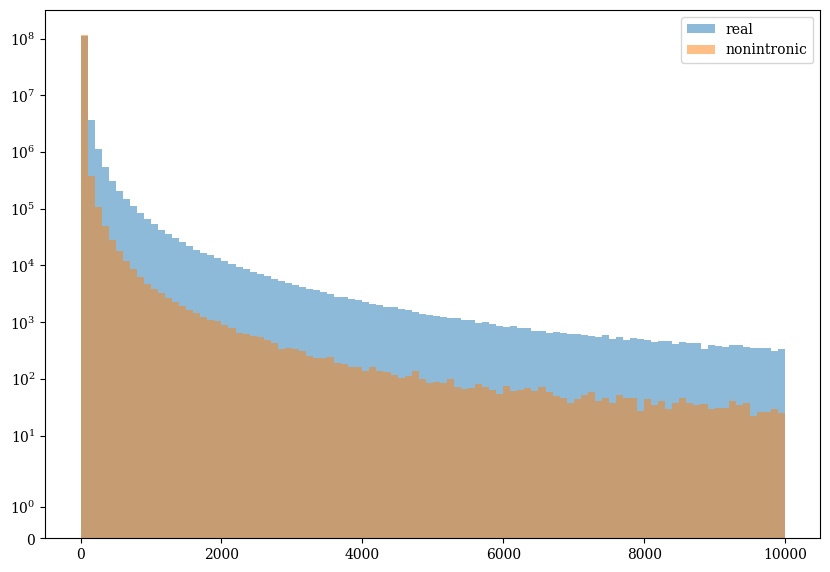

In [9]:
# now to repeat the same for the computed statistics from gtex
sum_df = pd.read_csv(base_dir+"out_real/res_distrib.sum_tx_per_sample_loc")
sum_df = sum_df[sum_df["real"]>0][["real","nonintronic"]].reset_index(drop=True)
# now to compare the expression distributions of each
fig1, axes = plt.subplots(ncols=1,nrows=1,figsize=(10,7),dpi=100)

plt.hist(sum_df[sum_df["real"]<10000]["real"],bins=100, alpha=0.5, label='real')
plt.hist(sum_df[sum_df["nonintronic"]<10000]["nonintronic"],bins=100, alpha=0.5, label='nonintronic')
plt.yscale("symlog")
plt.legend(loc='upper right')

In [19]:
# what is noise to real fraction?
sum_df = pd.read_csv(base_dir+"out_real/res_distrib.sum_tx_per_sample_loc")
sum_df.head()

,all,real,intronic,nonintronic,polymerase,left
0,0,22.4287,0.00000,4.74343,0.0,0.0
1,0,0.0000,0.00000,2.07536,0.0,0.0
2,0,11.6001,0.00000,2.00033,0.0,0.0
3,0,0.0000,1.39187,0.00000,0.0,0.0
4,0,0.0000,0.00000,3.24944,0.0,0.0


In [20]:
sum_df["real"].sum()/(sum_df["real"].sum()+sum_df["nonintronic"].sum()+sum_df["intronic"].sum()+sum_df["polymerase"].sum())

0.7235241712654221

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c8c2a30b8>]],
      dtype=object)

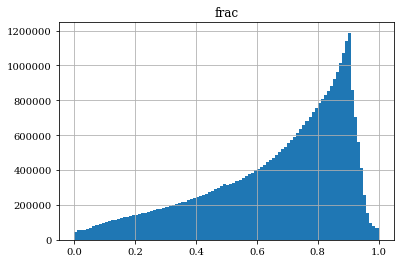

In [80]:
sum_df[sum_df["nonintronic"]>0].hist("frac",bins=100)

In [11]:
# first perform the conversion from .rda to .csv
r_cmd = ["R","-e",
         "load(file = \""+real_counts_path+".rda"+"\");write.csv(counts_matrix,\""+real_counts_path+".csv"+"\",quote=FALSE)"]
subprocess.call(r_cmd)
r_cmd = ["R","-e",
         "load(file = \""+nonint_counts_path+".rda"+"\");write.csv(counts_matrix,\""+nonint_counts_path+".csv"+"\",quote=FALSE)"]
subprocess.call(r_cmd)
r_cmd = ["R","-e",
         "load(file = \""+int_counts_path+".rda"+"\");write.csv(counts_matrix,\""+int_counts_path+".csv"+"\",quote=FALSE)"]
subprocess.call(r_cmd)
r_cmd = ["R","-e",
         "load(file = \""+pol_counts_path+".rda"+"\");write.csv(counts_matrix,\""+pol_counts_path+".csv"+"\",quote=FALSE)"]
subprocess.call(r_cmd)

0

In [12]:
# now can load respective datasets
realDF = pd.read_csv(real_counts_path+".csv")
realDF.columns = ["tid","npairs"]
nonintDF = pd.read_csv(nonint_counts_path+".csv")
nonintDF.columns = ["tid","npairs"]
intDF = pd.read_csv(int_counts_path+".csv")
intDF.columns = ["tid","npairs"]
polDF = pd.read_csv(pol_counts_path+".csv")
polDF.columns = ["tid","npairs"]

In [13]:
real_counts_path

'/home/sparrow/JHU/tx_noise//sim_samples_single_joint/res_distrib.real.sample0/sim_counts_matrix'

In [14]:
# make sure there is no overlap in transcriptIDs
all_tids = realDF["tid"].to_list()
all_tids.extend(nonintDF["tid"].to_list())
all_tids.extend(intDF["tid"].to_list())
all_tids.extend(polDF["tid"].to_list())
assert len(all_tids)==len(set(all_tids)),"duplicate tids"

In [20]:
# now can load salmon outputs and add it to the realDF
slmn_real = pd.read_csv(out_dir+"sim_samples_single_joint/slmn.real.sample0/quant.sf",sep="\t")
slmn_real.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_real.columns = ["tid","slmn_real_nreads"]
slmn_real_nonint = pd.read_csv(out_dir+"sim_samples_single_joint/slmn.real_nonint.sample0/quant.sf",sep="\t")
slmn_real_nonint.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_real_nonint.columns = ["tid","slmn_real_nonint_nreads"]
slmn_real_int = pd.read_csv(out_dir+"sim_samples_single_joint/slmn.real_int.sample0/quant.sf",sep="\t")
slmn_real_int.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_real_int.columns = ["tid","slmn_real_int_nreads"]
slmn_real_pol = pd.read_csv(out_dir+"sim_samples_single_joint/slmn.real_pol.sample0/quant.sf",sep="\t")
slmn_real_pol.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_real_pol.columns = ["tid","slmn_real_pol_nreads"]
slmn_all = pd.read_csv(out_dir+"sim_samples_single_joint/slmn.all.sample0/quant.sf",sep="\t")
slmn_all.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_all.columns = ["tid","slmn_all_nreads"]

In [21]:
# now can load salmon outputs and add it to the realDF
klst_real = pd.read_csv(out_dir+"sim_samples_single_joint/klst.real.sample0/abundance.tsv",sep="\t")
klst_real.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_real.columns = ["tid","klst_real_nreads"]
klst_real_nonint = pd.read_csv(out_dir+"sim_samples_single_joint/klst.real_nonint.sample0/abundance.tsv",sep="\t")
klst_real_nonint.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_real_nonint.columns = ["tid","klst_real_nonint_nreads"]
klst_real_int = pd.read_csv(out_dir+"sim_samples_single_joint/klst.real_int.sample0/abundance.tsv",sep="\t")
klst_real_int.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_real_int.columns = ["tid","klst_real_int_nreads"]
klst_real_pol = pd.read_csv(out_dir+"sim_samples_single_joint/klst.real_pol.sample0/abundance.tsv",sep="\t")
klst_real_pol.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_real_pol.columns = ["tid","klst_real_pol_nreads"]
klst_all = pd.read_csv(out_dir+"sim_samples_single_joint/klst.all.sample0/abundance.tsv",sep="\t")
klst_all.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_all.columns = ["tid","klst_all_nreads"]

In [22]:
# the difficulty here is that I am not sure we are computing nreads for Stringtie correctly
# since coverages are uneven along the length of the transcript, which implies
# that the coverage is averaged, which implies that it might not be accurate

# now need to load stringtie assemblies and convert coverage to the number of reads
# for this we will need effective length of transcripts
strg_real=pd.read_csv(out_dir+"sim_samples_single_joint/strg.real.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_real.dropna(axis=0,inplace=True)
strg_real = strg_real[strg_real["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_real_exons=strg_real[strg_real["type"]=="exon"].reset_index(drop=True)
strg_real=strg_real[strg_real["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_real["cov"]=strg_real["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real["cov"]=strg_real["cov"].astype(float)
strg_real["tid"]=strg_real["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real=strg_real[["tid","cov"]]
strg_real.columns=["tid","cov"]
strg_real.sort_values(by="tid")
assert len(strg_real[strg_real.duplicated("tid")])==0,"duplicate tids in strg_real"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_real_exons["tid"]=strg_real_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_exons["elen"] = strg_real_exons["end"]-strg_real_exons["start"]
strg_real_exons = strg_real_exons[["tid","elen"]]
strg_real_exons = strg_real_exons.groupby(by="tid").sum().reset_index()
strg_real = strg_real.merge(strg_real_exons,on="tid",how="left",indicator=True)
assert len(strg_real[strg_real["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_real.drop("_merge",axis=1,inplace=True)
strg_real["cov"]=strg_real["cov"].fillna(value=np.nan)
strg_real["strg_real_nreads"]=(strg_real["cov"]*strg_real["elen"])/readlen
strg_real.drop(["cov","elen"],axis=1,inplace=True)
strg_real.head()

,tid,strg_real_nreads
0,ALL_00206922,5.304845
1,ALL_00207119,29.156152
2,ALL_00383901,11.282534
3,ALL_00207484,2.618077
4,ALL_00207225,5.304845


In [23]:
strg_real_nonint=pd.read_csv(out_dir+"sim_samples_single_joint/strg.real_nonint.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_real_nonint.dropna(axis=0,inplace=True)
strg_real_nonint = strg_real_nonint[strg_real_nonint["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_real_nonint_exons=strg_real_nonint[strg_real_nonint["type"]=="exon"].reset_index(drop=True)
strg_real_nonint=strg_real_nonint[strg_real_nonint["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_real_nonint["cov"]=strg_real_nonint["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_nonint["cov"]=strg_real_nonint["cov"].astype(float)
strg_real_nonint["tid"]=strg_real_nonint["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_nonint=strg_real_nonint[["tid","cov"]]
strg_real_nonint.columns=["tid","cov"]
strg_real_nonint.sort_values(by="tid")
assert len(strg_real_nonint[strg_real_nonint.duplicated("tid")])==0,"duplicate tids in strg_real_nonint"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_real_nonint_exons["tid"]=strg_real_nonint_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_nonint_exons["elen"] = strg_real_nonint_exons["end"]-strg_real_nonint_exons["start"]
strg_real_nonint_exons = strg_real_nonint_exons[["tid","elen"]]
strg_real_nonint_exons = strg_real_nonint_exons.groupby(by="tid").sum().reset_index()
strg_real_nonint = strg_real_nonint.merge(strg_real_nonint_exons,on="tid",how="left",indicator=True)
assert len(strg_real_nonint[strg_real_nonint["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_real_nonint.drop("_merge",axis=1,inplace=True)
strg_real_nonint["cov"]=strg_real_nonint["cov"].fillna(value=np.nan)
strg_real_nonint["strg_real_nonint_nreads"]=(strg_real_nonint["cov"]*strg_real_nonint["elen"])/readlen
strg_real_nonint.drop(["cov","elen"],axis=1,inplace=True)
strg_real_nonint.head()

,tid,strg_real_nonint_nreads
0,ALL_02554820,7.400362
1,ALL_00000021,17.977122
2,ALL_02450881,29.894693
3,ALL_00783170,89.763366
4,ALL_00206278,39.252360


In [24]:
strg_real_int=pd.read_csv(out_dir+"sim_samples_single_joint/strg.real_int.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_real_int.dropna(axis=0,inplace=True)
strg_real_int = strg_real_int[strg_real_int["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_real_int_exons=strg_real_int[strg_real_int["type"]=="exon"].reset_index(drop=True)
strg_real_int=strg_real_int[strg_real_int["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_real_int["cov"]=strg_real_int["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_int["cov"]=strg_real_int["cov"].astype(float)
strg_real_int["tid"]=strg_real_int["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_int=strg_real_int[["tid","cov"]]
strg_real_int.columns=["tid","cov"]
strg_real_int.sort_values(by="tid")
assert len(strg_real_int[strg_real_int.duplicated("tid")])==0,"duplicate tids in strg_real_int"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_real_int_exons["tid"]=strg_real_int_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_int_exons["elen"] = strg_real_int_exons["end"]-strg_real_int_exons["start"]
strg_real_int_exons = strg_real_int_exons[["tid","elen"]]
strg_real_int_exons = strg_real_int_exons.groupby(by="tid").sum().reset_index()
strg_real_int = strg_real_int.merge(strg_real_int_exons,on="tid",how="left",indicator=True)
assert len(strg_real_int[strg_real_int["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_real_int.drop("_merge",axis=1,inplace=True)
strg_real_int["cov"]=strg_real_int["cov"].fillna(value=np.nan)
strg_real_int["strg_real_int_nreads"]=(strg_real_int["cov"]*strg_real_int["elen"])/readlen
strg_real_int.drop(["cov","elen"],axis=1,inplace=True)
strg_real_int.head()

,tid,strg_real_int_nreads
0,ALL_02554820,7.400362
1,ALL_00000021,17.977122
2,ALL_02450881,10.471228
3,ALL_00783170,81.364007
4,ALL_00901672,24.989141


In [25]:
strg_real_pol=pd.read_csv(out_dir+"sim_samples_single_joint/strg.real_pol.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_real_pol.dropna(axis=0,inplace=True)
strg_real_pol = strg_real_pol[strg_real_pol["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_real_pol_exons=strg_real_pol[strg_real_pol["type"]=="exon"].reset_index(drop=True)
strg_real_pol=strg_real_pol[strg_real_pol["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_real_pol["cov"]=strg_real_pol["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_pol["cov"]=strg_real_pol["cov"].astype(float)
strg_real_pol["tid"]=strg_real_pol["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_pol=strg_real_pol[["tid","cov"]]
strg_real_pol.columns=["tid","cov"]
strg_real_pol.sort_values(by="tid")
assert len(strg_real_pol[strg_real_pol.duplicated("tid")])==0,"duplicate tids in strg_real_pol"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_real_pol_exons["tid"]=strg_real_pol_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_pol_exons["elen"] = strg_real_pol_exons["end"]-strg_real_pol_exons["start"]
strg_real_pol_exons = strg_real_pol_exons[["tid","elen"]]
strg_real_pol_exons = strg_real_pol_exons.groupby(by="tid").sum().reset_index()
strg_real_pol = strg_real_pol.merge(strg_real_pol_exons,on="tid",how="left",indicator=True)
assert len(strg_real_pol[strg_real_pol["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_real_pol.drop("_merge",axis=1,inplace=True)
strg_real_pol["cov"]=strg_real_pol["cov"].fillna(value=np.nan)
strg_real_pol["strg_real_pol_nreads"]=(strg_real_pol["cov"]*strg_real_pol["elen"])/readlen
strg_real_pol.drop(["cov","elen"],axis=1,inplace=True)
strg_real_pol.head()

,tid,strg_real_pol_nreads
0,ALL_02554820,7.400362
1,ALL_00000021,17.977122
2,ALL_02450881,10.471228
3,ALL_00783170,81.364007
4,ALL_00901672,24.989141


In [26]:
strg_all=pd.read_csv(out_dir+"sim_samples_single_joint/strg.all.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_all.dropna(axis=0,inplace=True)
strg_all = strg_all[strg_all["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_all_exons=strg_all[strg_all["type"]=="exon"].reset_index(drop=True)
strg_all=strg_all[strg_all["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_all["cov"]=strg_all["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_all["cov"]=strg_all["cov"].astype(float)
strg_all["tid"]=strg_all["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_all=strg_all[["tid","cov"]]
strg_all.columns=["tid","cov"]
strg_all.sort_values(by="tid")
assert len(strg_all[strg_all.duplicated("tid")])==0,"duplicate tids in strg_all"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_all_exons["tid"]=strg_all_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_all_exons["elen"] = strg_all_exons["end"]-strg_all_exons["start"]
strg_all_exons = strg_all_exons[["tid","elen"]]
strg_all_exons = strg_all_exons.groupby(by="tid").sum().reset_index()
strg_all = strg_all.merge(strg_all_exons,on="tid",how="left",indicator=True)
assert len(strg_all[strg_all["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_all.drop("_merge",axis=1,inplace=True)
strg_all["cov"]=strg_all["cov"].fillna(value=np.nan)
strg_all["strg_all_nreads"]=(strg_all["cov"]*strg_all["elen"])/readlen
strg_all.drop(["cov","elen"],axis=1,inplace=True)
strg_all.head()

,tid,strg_all_nreads
0,ALL_02554820,7.400362
1,ALL_00000021,17.977122
2,ALL_02450881,29.894693
3,ALL_00783170,89.050904
4,ALL_00206278,38.876387


In [27]:
realDF = realDF.merge(slmn_real,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn real"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(slmn_real_nonint,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn real_nonint"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(slmn_real_int,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn real_int"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(slmn_real_pol,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn real_pol"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(slmn_all,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn all"
realDF.drop("_merge",axis=1,inplace=True)

realDF = realDF.merge(klst_real,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst real"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(klst_real_nonint,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst real_nonint"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(klst_real_int,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst real_int"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(klst_real_pol,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst real_pol"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(klst_all,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst all"
realDF.drop("_merge",axis=1,inplace=True)

realDF = realDF.merge(strg_real,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg real"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(strg_real_nonint,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg real_nonint"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(strg_real_int,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg real_int"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(strg_real_pol,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg real_pol"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(strg_all,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg all"
realDF.drop("_merge",axis=1,inplace=True)

realDF.head()

,tid,npairs,slmn_real_nreads,slmn_real_nonint_nreads,slmn_real_int_nreads,slmn_real_pol_nreads,slmn_all_nreads,klst_real_nreads,klst_real_nonint_nreads,klst_real_int_nreads,klst_real_pol_nreads,klst_all_nreads,strg_real_nreads,strg_real_nonint_nreads,strg_real_int_nreads,strg_real_pol_nreads,strg_all_nreads
0,ALL_11454414,13,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN,NaN
1,ALL_11429318,11,11.0,39.0,11.0,695.0,723.0,10.0,34.0,10.0,771.0,795.0,NaN,NaN,NaN,10.625375,30.926670
2,ALL_11599814,97,97.0,97.0,97.0,97.0,97.0,96.0,96.0,96.0,96.0,96.0,36.622139,36.622139,36.625278,36.622121,36.624043
3,ALL_11245865,56,56.0,56.0,56.0,56.0,56.0,55.0,55.0,55.0,55.0,55.0,55.948093,55.948093,55.948093,55.948093,55.948093
4,ALL_11245962,17,17.0,34.0,17.0,41.0,58.0,17.0,17.0,17.0,30.0,30.0,8.305496,12.372671,8.305496,15.768583,19.835872


In [28]:
# cleanup
realDF.fillna(0,inplace=True)
realDF

,tid,npairs,slmn_real_nreads,slmn_real_nonint_nreads,slmn_real_int_nreads,slmn_real_pol_nreads,slmn_all_nreads,klst_real_nreads,klst_real_nonint_nreads,klst_real_int_nreads,klst_real_pol_nreads,klst_all_nreads,strg_real_nreads,strg_real_nonint_nreads,strg_real_int_nreads,strg_real_pol_nreads,strg_all_nreads
0,ALL_11454414,13,13.000,13.00,13.000,13.00,13.000,13.0000,13.0000,13.0000,13.0000,13.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ALL_11429318,11,11.000,39.00,11.000,695.00,723.000,10.0000,34.0000,10.0000,771.0000,795.0000,0.000000,0.000000,0.000000,10.625375,30.926670
2,ALL_11599814,97,97.000,97.00,97.000,97.00,97.000,96.0000,96.0000,96.0000,96.0000,96.0000,36.622139,36.622139,36.625278,36.622121,36.624043
3,ALL_11245865,56,56.000,56.00,56.000,56.00,56.000,55.0000,55.0000,55.0000,55.0000,55.0000,55.948093,55.948093,55.948093,55.948093,55.948093
4,ALL_11245962,17,17.000,34.00,17.000,41.00,58.000,17.0000,17.0000,17.0000,30.0000,30.0000,8.305496,12.372671,8.305496,15.768583,19.835872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22842,ALL_18048551,185,146.579,144.42,146.579,149.68,144.629,133.8300,126.9220,133.8300,133.8300,126.7120,142.337982,121.298077,142.337982,142.337982,121.298092
22843,ALL_18048553,28,0.000,0.00,0.000,0.00,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,10.922005,8.577317,10.922005,10.922005,8.577317
22844,ALL_18050790,15,15.000,68.00,15.000,15.00,68.000,15.0000,71.0000,15.0000,15.0000,71.0000,14.975193,68.571121,14.975193,14.975193,68.571121
22845,ALL_29380323,22,22.000,22.00,22.000,22.00,22.000,21.8253,21.7249,21.8253,21.8253,21.7249,21.468428,21.468428,21.468428,21.468428,21.468428


Text(0.9, 0.1, 'Undetected = 4945')

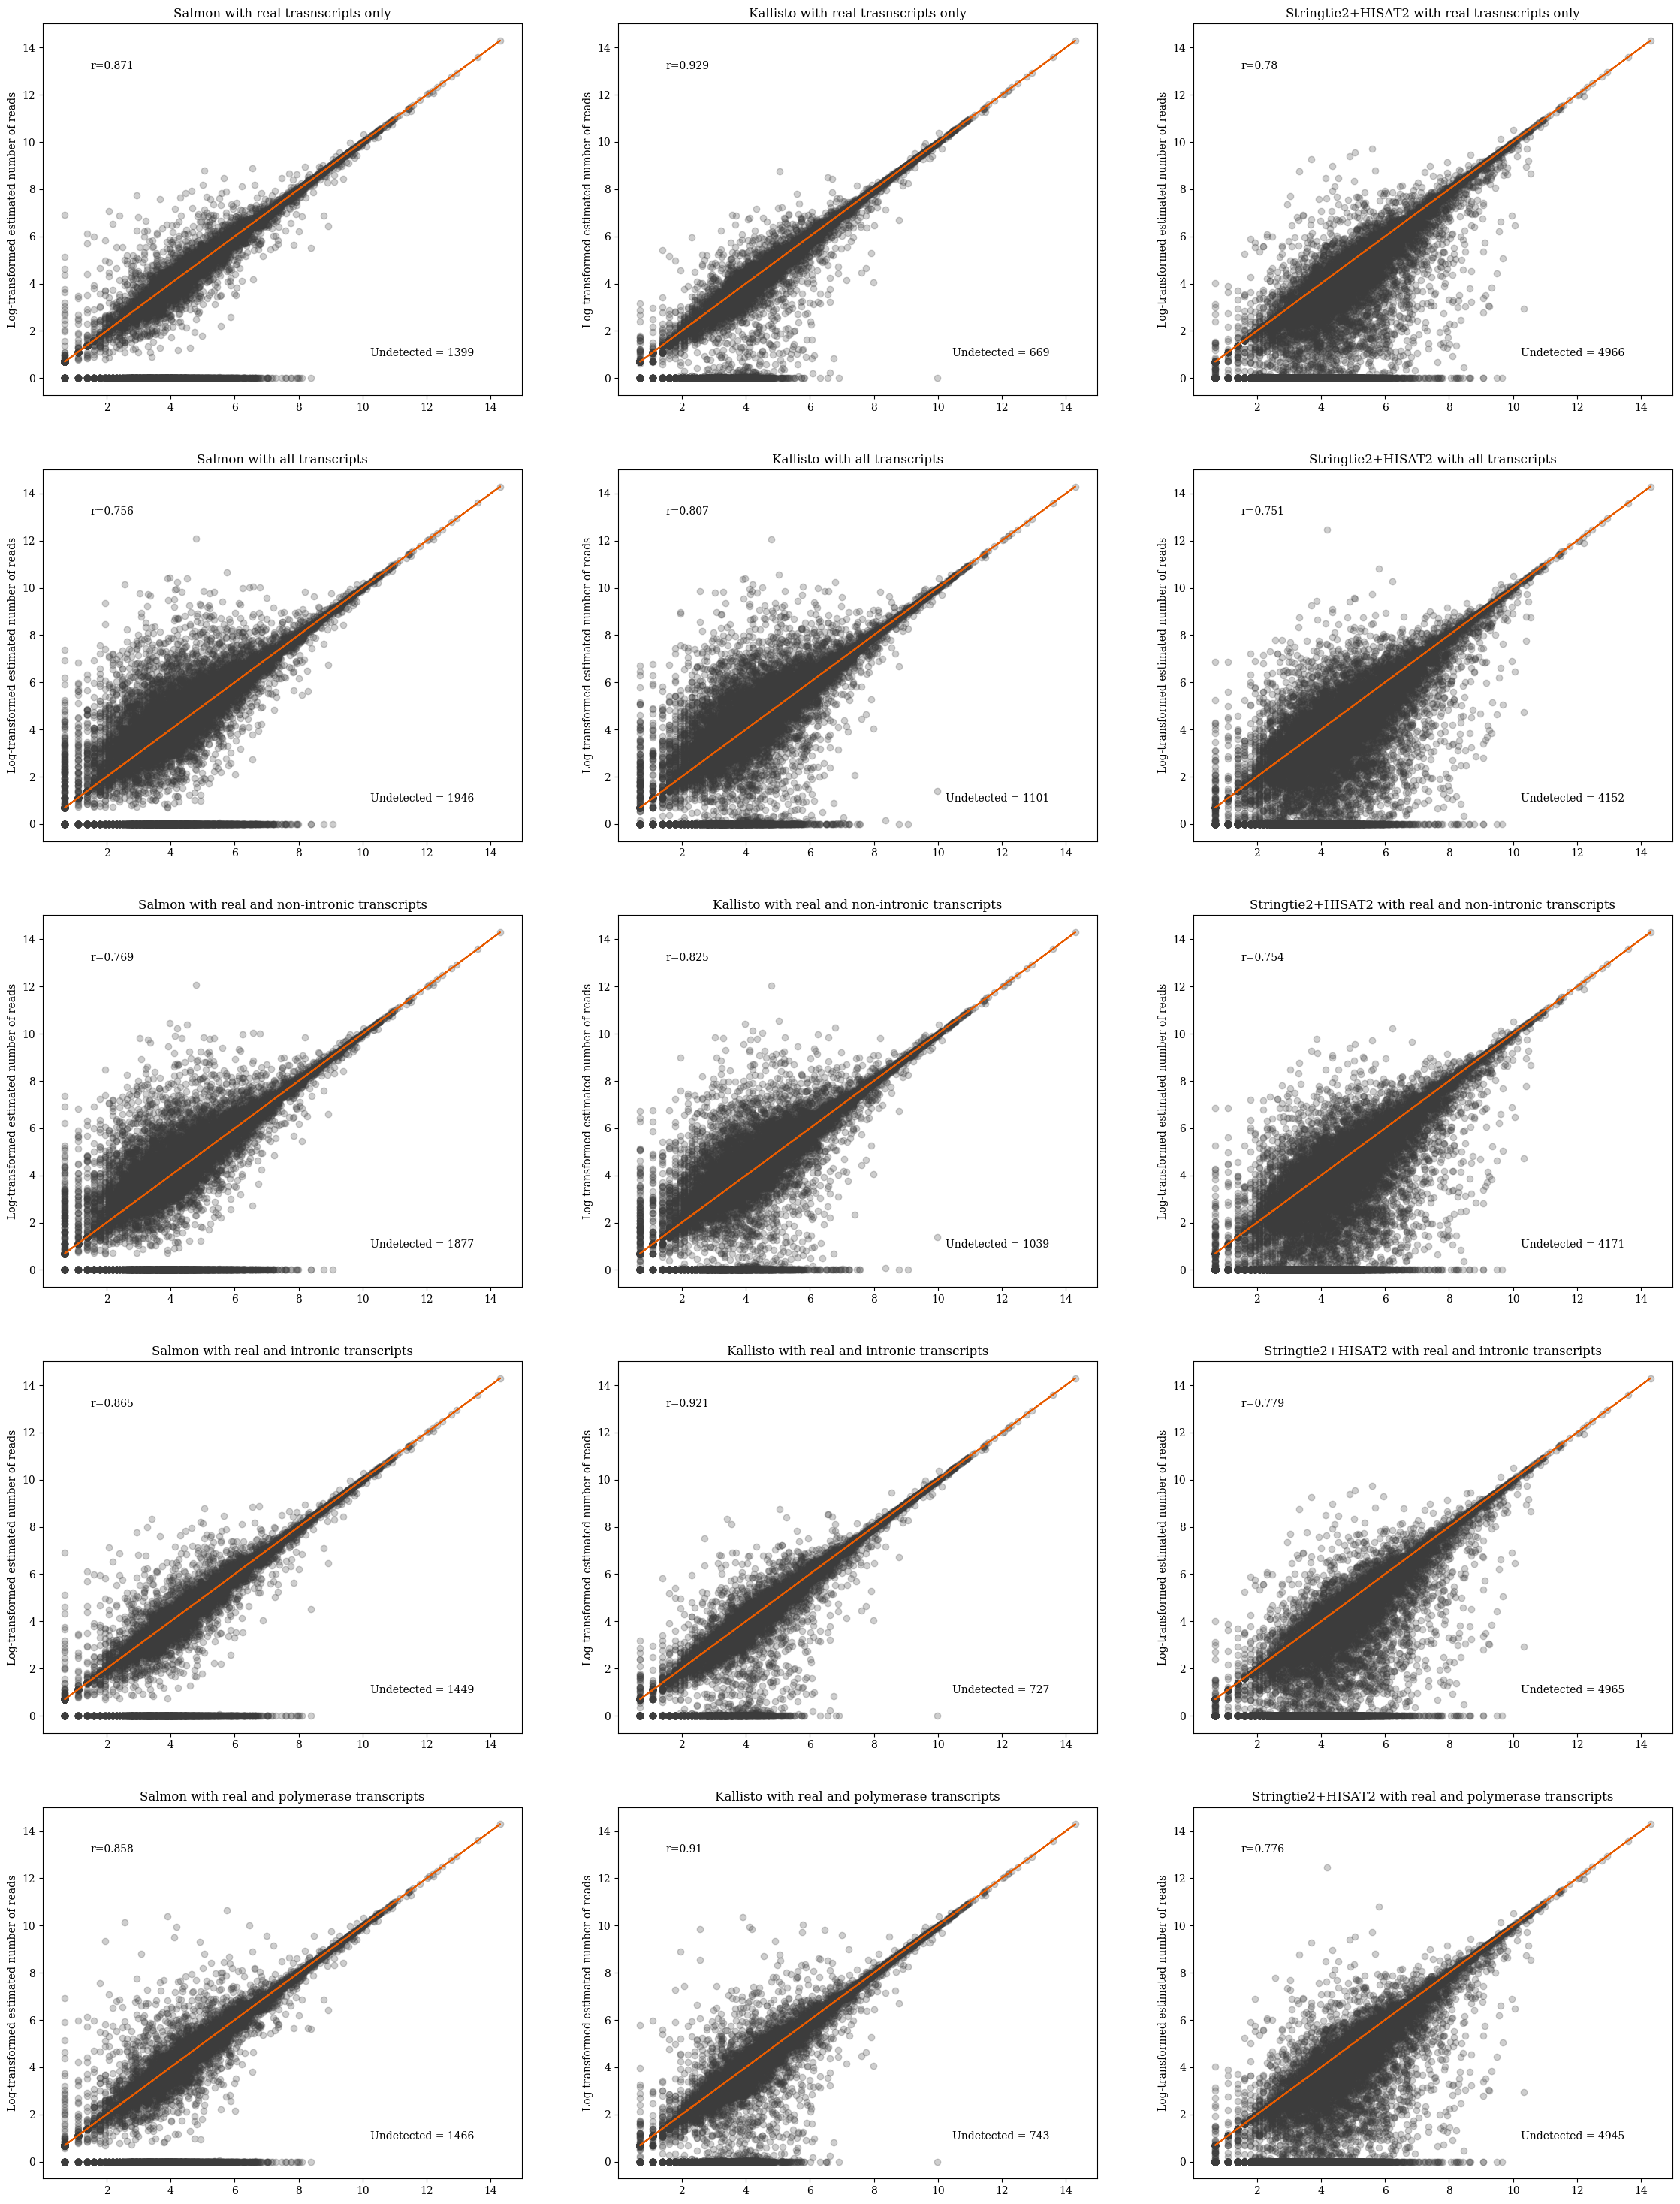

In [30]:
# compare correctness of the alignments
fig1, axes = plt.subplots(ncols=3,nrows=5,figsize=(28,38),dpi=100)

realDF["npairs_log"]=np.log(realDF["npairs"].replace(np.nan,0)+1)
realDF["slmn_real_nreads_log"]=np.log(realDF["slmn_real_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_real_nreads_log"])
axes[0,0].yaxis.tick_left()
axes[0,0].scatter(realDF["npairs_log"],realDF["slmn_real_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[0,0].set_title("Salmon with real trasnscripts only")
axes[0,0].set_ylabel("Log-transformed estimated number of reads")
axes[0,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[0,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[0,0].transAxes)
axes[0,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_real_nreads"].isnull())|(realDF["slmn_real_nreads"]==0)]))),ha="right",va="bottom",transform=axes[0,0].transAxes)

realDF["slmn_all_nreads_log"]=np.log(realDF["slmn_all_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_all_nreads_log"])
axes[1,0].yaxis.tick_left()
axes[1,0].scatter(realDF["npairs_log"],realDF["slmn_all_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[1,0].set_title("Salmon with all transcripts")
axes[1,0].set_ylabel("Log-transformed estimated number of reads")
axes[1,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[1,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[1,0].transAxes)
axes[1,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_all_nreads"].isnull())|(realDF["slmn_all_nreads"]==0)]))),ha="right",va="bottom",transform=axes[1,0].transAxes)

realDF["slmn_real_nonint_nreads_log"]=np.log(realDF["slmn_real_nonint_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_real_nonint_nreads_log"])
axes[2,0].yaxis.tick_left()
axes[2,0].scatter(realDF["npairs_log"],realDF["slmn_real_nonint_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[2,0].set_title("Salmon with real and non-intronic transcripts")
axes[2,0].set_ylabel("Log-transformed estimated number of reads")
axes[2,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[2,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[2,0].transAxes)
axes[2,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_real_nonint_nreads"].isnull())|(realDF["slmn_real_nonint_nreads"]==0)]))),ha="right",va="bottom",transform=axes[2,0].transAxes)

realDF["slmn_real_int_nreads_log"]=np.log(realDF["slmn_real_int_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_real_int_nreads_log"])
axes[3,0].yaxis.tick_left()
axes[3,0].scatter(realDF["npairs_log"],realDF["slmn_real_int_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[3,0].set_title("Salmon with real and intronic transcripts")
axes[3,0].set_ylabel("Log-transformed estimated number of reads")
axes[3,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[3,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[3,0].transAxes)
axes[3,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_real_int_nreads"].isnull())|(realDF["slmn_real_int_nreads"]==0)]))),ha="right",va="bottom",transform=axes[3,0].transAxes)

realDF["slmn_real_pol_nreads_log"]=np.log(realDF["slmn_real_pol_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_real_pol_nreads_log"])
axes[4,0].yaxis.tick_left()
axes[4,0].scatter(realDF["npairs_log"],realDF["slmn_real_pol_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[4,0].set_title("Salmon with real and polymerase transcripts")
axes[4,0].set_ylabel("Log-transformed estimated number of reads")
axes[4,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[4,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[4,0].transAxes)
axes[4,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_real_pol_nreads"].isnull())|(realDF["slmn_real_pol_nreads"]==0)]))),ha="right",va="bottom",transform=axes[4,0].transAxes)


realDF["klst_real_nreads_log"]=np.log(realDF["klst_real_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_real_nreads_log"])
axes[0,1].yaxis.tick_left()
axes[0,1].scatter(realDF["npairs_log"],realDF["klst_real_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[0,1].set_title("Kallisto with real trasnscripts only")
axes[0,1].set_ylabel("Log-transformed estimated number of reads")
axes[0,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[0,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[0,1].transAxes)
axes[0,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_real_nreads"].isnull())|(realDF["klst_real_nreads"]==0)]))),ha="right",va="bottom",transform=axes[0,1].transAxes)

realDF["klst_all_nreads_log"]=np.log(realDF["klst_all_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_all_nreads_log"])
axes[1,1].yaxis.tick_left()
axes[1,1].scatter(realDF["npairs_log"],realDF["klst_all_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[1,1].set_title("Kallisto with all transcripts")
axes[1,1].set_ylabel("Log-transformed estimated number of reads")
axes[1,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[1,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[1,1].transAxes)
axes[1,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_all_nreads"].isnull())|(realDF["klst_all_nreads"]==0)]))),ha="right",va="bottom",transform=axes[1,1].transAxes)

realDF["klst_real_nonint_nreads_log"]=np.log(realDF["klst_real_nonint_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_real_nonint_nreads_log"])
axes[2,1].yaxis.tick_left()
axes[2,1].scatter(realDF["npairs_log"],realDF["klst_real_nonint_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[2,1].set_title("Kallisto with real and non-intronic transcripts")
axes[2,1].set_ylabel("Log-transformed estimated number of reads")
axes[2,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[2,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[2,1].transAxes)
axes[2,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_real_nonint_nreads"].isnull())|(realDF["klst_real_nonint_nreads"]==0)]))),ha="right",va="bottom",transform=axes[2,1].transAxes)

realDF["klst_real_int_nreads_log"]=np.log(realDF["klst_real_int_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_real_int_nreads_log"])
axes[3,1].yaxis.tick_left()
axes[3,1].scatter(realDF["npairs_log"],realDF["klst_real_int_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[3,1].set_title("Kallisto with real and intronic transcripts")
axes[3,1].set_ylabel("Log-transformed estimated number of reads")
axes[3,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[3,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[3,1].transAxes)
axes[3,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_real_int_nreads"].isnull())|(realDF["klst_real_int_nreads"]==0)]))),ha="right",va="bottom",transform=axes[3,1].transAxes)

realDF["klst_real_pol_nreads_log"]=np.log(realDF["klst_real_pol_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_real_pol_nreads_log"])
axes[4,1].yaxis.tick_left()
axes[4,1].scatter(realDF["npairs_log"],realDF["klst_real_pol_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[4,1].set_title("Kallisto with real and polymerase transcripts")
axes[4,1].set_ylabel("Log-transformed estimated number of reads")
axes[4,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[4,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[4,1].transAxes)
axes[4,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_real_pol_nreads"].isnull())|(realDF["klst_real_pol_nreads"]==0)]))),ha="right",va="bottom",transform=axes[4,1].transAxes)


realDF["strg_real_nreads_log"]=np.log(realDF["strg_real_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_real_nreads_log"])
axes[0,2].yaxis.tick_left()
axes[0,2].scatter(realDF["npairs_log"],realDF["strg_real_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[0,2].set_title("Stringtie2+HISAT2 with real trasnscripts only")
axes[0,2].set_ylabel("Log-transformed estimated number of reads")
axes[0,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[0,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[0,2].transAxes)
axes[0,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_real_nreads"].isnull())|(realDF["strg_real_nreads"]==0)]))),ha="right",va="bottom",transform=axes[0,2].transAxes)

realDF["strg_all_nreads_log"]=np.log(realDF["strg_all_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_all_nreads_log"])
axes[1,2].yaxis.tick_left()
axes[1,2].scatter(realDF["npairs_log"],realDF["strg_all_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[1,2].set_title("Stringtie2+HISAT2 with all transcripts")
axes[1,2].set_ylabel("Log-transformed estimated number of reads")
axes[1,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[1,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[1,2].transAxes)
axes[1,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_all_nreads"].isnull())|(realDF["strg_all_nreads"]==0)]))),ha="right",va="bottom",transform=axes[1,2].transAxes)

realDF["strg_real_nonint_nreads_log"]=np.log(realDF["strg_real_nonint_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_real_nonint_nreads_log"])
axes[2,2].yaxis.tick_left()
axes[2,2].scatter(realDF["npairs_log"],realDF["strg_real_nonint_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[2,2].set_title("Stringtie2+HISAT2 with real and non-intronic transcripts")
axes[2,2].set_ylabel("Log-transformed estimated number of reads")
axes[2,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[2,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[2,2].transAxes)
axes[2,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_real_nonint_nreads"].isnull())|(realDF["strg_real_nonint_nreads"]==0)]))),ha="right",va="bottom",transform=axes[2,2].transAxes)

realDF["strg_real_int_nreads_log"]=np.log(realDF["strg_real_int_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_real_int_nreads_log"])
axes[3,2].yaxis.tick_left()
axes[3,2].scatter(realDF["npairs_log"],realDF["strg_real_int_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[3,2].set_title("Stringtie2+HISAT2 with real and intronic transcripts")
axes[3,2].set_ylabel("Log-transformed estimated number of reads")
axes[3,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[3,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[3,2].transAxes)
axes[3,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_real_int_nreads"].isnull())|(realDF["strg_real_int_nreads"]==0)]))),ha="right",va="bottom",transform=axes[3,2].transAxes)

realDF["strg_real_pol_nreads_log"]=np.log(realDF["strg_real_pol_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_real_pol_nreads_log"])
axes[4,2].yaxis.tick_left()
axes[4,2].scatter(realDF["npairs_log"],realDF["strg_real_pol_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[4,2].set_title("Stringtie2+HISAT2 with real and polymerase transcripts")
axes[4,2].set_ylabel("Log-transformed estimated number of reads")
axes[4,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[4,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[4,2].transAxes)
axes[4,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_real_pol_nreads"].isnull())|(realDF["strg_real_pol_nreads"]==0)]))),ha="right",va="bottom",transform=axes[4,2].transAxes)

# plt.savefig(png_dir+"/readtx.png")

In [37]:
# let's isolate the dropouts and investigate them
strg_realDF_tids = set(realDF[realDF["strg_real_nreads"]==0]["tid"])
real_gtf = pd.read_csv(out_dir+"sim_samples_single_joint/res_distrib.real.sample0.gtf",names=gff3cols,comment="#",sep="\t")
edf_real = real_gtf[real_gtf["type"]=="exon"].reset_index(drop=True)
edf_real["tid"] = edf_real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
edf_real = edf_real[edf_real["tid"].isin(strg_realDF_tids)].reset_index(drop=True)
edf_real["gid"] = edf_real["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
edf_real["len"] = edf_real["end"]-edf_real["start"]
edf_real = edf_real[["tid","gid","len"]]
edf_real = edf_real.groupby("tid").agg({"len":"sum","gid":lambda x: ";".join(set(x))}).reset_index()
assert len(edf_real[edf_real["gid"].str.contains(";")]) == 0,"multiple loci groupped together"
edf_real.columns = ["tid","elen","gid"]
edf_real.head()

,tid,elen,gid
0,ALL_00006773,8649,XLOC_000168
1,ALL_00009540,5327,XLOC_000312
2,ALL_00011493,5182,XLOC_000395
3,ALL_00012609,4670,XLOC_000415
4,ALL_00012997,10534,XLOC_000415


In [41]:
edf_real = edf_real.merge(realDF[["tid","npairs"]],how="left")
edf_real["cov"] = (edf_real["npairs"]*readlen)/edf_real["elen"]
edf_real.sort_values(by="cov",ascending=False).head(n=50)

,tid,elen,gid,npairs,cov
653,ALL_03589658,758,XLOC_117403,8753,1166.296834
4879,ALL_29739618,478,XLOC_1441527,4630,978.305439
4054,ALL_23609245,1313,XLOC_1117906,8636,664.307692
497,ALL_02568631,2127,XLOC_008333,13289,631.024448
4499,ALL_27848994,415,XLOC_1295232,1743,424.200000
4226,ALL_25425770,1497,XLOC_1220167,5837,393.812291
4147,ALL_24536812,761,XLOC_1120440,2334,309.768725
639,ALL_03362697,1366,XLOC_122714,3692,272.980966
3492,ALL_18759558,2274,XLOC_806569,5590,248.280563
3581,ALL_19477368,1819,XLOC_809748,3764,208.996152


([<matplotlib.axis.XTick at 0x7f5301ac5198>,
 <a list of 11 Text xticklabel objects>)

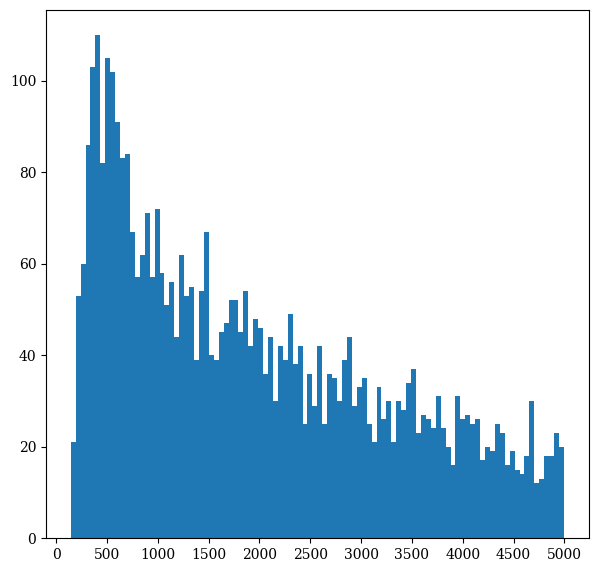

In [39]:
fig = plt.figure(figsize=(7,7),dpi=100)
plt.hist(edf_real[edf_real["elen"]<5000]["elen"],bins=100)
plt.xticks(np.arange(0, 5500, step=500))
# edf_real[edf_real["elen"]<5000].hist("elen",bins=100)